In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from src.utils import load_all_locations, load_all_vals, load_val
from src.utils.data_loader import load_val_dates

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

# Torch
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as torch_data


sns.set_theme(style="darkgrid")

In [3]:
data = load_all_locations()
vals = load_all_vals()

In [4]:
def create_time_features(df):
    df['hour'] = df.time.dt.hour
    df['dayofmonth'] = df.time.dt.day
    df['dayofweek'] = df.time.dt.dayofweek
    df['quarter'] = df.time.dt.quarter
    df['month'] = df.time.dt.month
    df['year'] = df.time.dt.year
    df['dayofyear'] = df.time.dt.dayofyear
    return df

In [5]:
X_val = vals.copy()[vals.time.isin(load_val_dates())]

# One-hot Encoding
X_val = X_val.reset_index().drop(columns="index")
one_hot = pd.get_dummies(X_val["location"]).astype(int)
X_val = X_val.drop("location", axis=1)
X_val = pd.merge(X_val, one_hot, left_index=True, right_index=True)

# Add time based features
X_val = create_time_features(X_val)

# Drop datetime
X_val = X_val.drop(columns=["time"])

# Drop missing column values
nan_columns = X_val.columns[X_val.isna().any()].tolist()
X_val = X_val.drop(columns=nan_columns)
X_val

,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,...,A,B,C,hour,dayofmonth,dayofweek,quarter,month,year,dayofyear
0,4.325,1.28675,0.000000,0.000000,0.0,271.650024,0.000000,0.000000,0.000000,0.000000,...,1,0,0,0,1,0,2,5,2023,121
1,4.275,1.28600,0.000000,0.000000,0.0,271.450012,0.000000,0.000000,0.000000,0.000000,...,1,0,0,1,1,0,2,5,2023,121
2,4.150,1.28375,0.000000,0.000000,0.0,271.049988,0.000000,0.000000,0.000000,0.000000,...,1,0,0,2,1,0,2,5,2023,121
3,4.025,1.28200,10124.424805,11.675000,0.0,270.649994,9.375000,16845.226562,2.100000,3765.350098,...,1,0,0,3,1,0,2,5,2023,121
4,3.900,1.28100,141748.593750,76.875000,0.0,270.375000,47.400002,102209.703125,25.450001,49571.199219,...,1,0,0,4,1,0,2,5,2023,121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,8.400,1.19675,475981.375000,84.775002,0.0,281.700012,32.200001,162567.531250,13.450001,53064.921875,...,0,0,1,19,3,0,3,7,2023,184
2156,8.600,1.20000,183261.343750,24.549999,0.0,282.024994,13.875000,82875.351562,2.400000,28523.800781,...,0,0,1,20,3,0,3,7,2023,184
2157,8.875,1.20350,36831.074219,1.225000,0.0,282.350006,1.250000,27210.250000,0.000000,4322.475098,...,0,0,1,21,3,0,3,7,2023,184
2158,9.000,1.20650,344.575012,0.000000,0.0,282.600006,0.000000,2242.149902,0.000000,0.000000,...,0,0,1,22,3,0,3,7,2023,184


In [6]:
X, y = data[0].copy(), data[1].copy()


# One-hot Encoding
X = X.reset_index().drop(columns="index")
one_hot = pd.get_dummies(X["location"]).astype(int)
X = X.drop("location", axis=1)
X = pd.merge(X, one_hot, left_index=True, right_index=True)

# Add time based features
X = create_time_features(X)

# Drop datetime
X = X.drop(columns=["time"])

# Drop missing column values
nan_columns = X.columns[X.isna().any()].tolist()
X = X.drop(columns=nan_columns)

X


,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,...,A,B,C,hour,dayofmonth,dayofweek,quarter,month,year,dayofyear
0,7.700,1.22825,0.000000,0.000,0.0,280.299988,0.000,0.000000,0.00,0.000000,...,1,0,0,22,2,6,2,6,2019,153
1,7.700,1.22350,0.000000,0.000,0.0,280.299988,0.000,0.000000,0.00,0.000000,...,1,0,0,23,2,6,2,6,2019,153
2,7.875,1.21975,0.000000,0.000,0.0,280.649994,0.000,0.000000,0.00,0.000000,...,1,0,0,0,3,0,2,6,2019,154
3,8.425,1.21800,208.649994,0.750,0.0,281.674988,0.300,526.775024,0.00,0.000000,...,1,0,0,1,3,0,2,6,2019,154
4,8.950,1.21800,32468.150391,23.100,0.0,282.500000,11.975,22068.949219,0.15,282.975006,...,1,0,0,2,3,0,2,6,2019,154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81113,4.400,1.27550,84010.148438,4.175,0.0,272.024994,2.775,54774.000000,0.00,9934.575195,...,0,0,1,19,30,6,2,4,2023,120
81114,4.400,1.27850,2206.800049,0.000,0.0,271.950012,0.000,4984.049805,0.00,0.000000,...,0,0,1,20,30,6,2,4,2023,120
81115,4.400,1.27900,0.000000,0.000,0.0,271.899994,0.000,0.000000,0.00,0.000000,...,0,0,1,21,30,6,2,4,2023,120
81116,4.400,1.27975,0.000000,0.000,0.0,271.950012,0.000,0.000000,0.00,0.000000,...,0,0,1,22,30,6,2,4,2023,120


In [7]:
X_train = X[X.set_type == "TRAIN"].copy().drop(columns=["set_type"])
X_train_scaler = MinMaxScaler()
X_train_scaler = X_train_scaler.fit(X_train)
X_train = X_train_scaler.transform(X_train)

y_train = y[y.set_type == "TRAIN"].copy()[["y"]]
y_train_scaler = MinMaxScaler()
y_train_scaler = y_train_scaler.fit(y_train)
y_train = y_train_scaler.transform(y_train)

X_testA = X[(X.set_type == "TEST") & (X.A == True)].copy().drop(columns=["set_type"])
y_testA = y[(y.set_type == "TEST") & (y.location == "A")].copy()[["y"]]

X_testB = X[(X.set_type == "TEST") & (X.B == True)].copy().drop(columns=["set_type"])
y_testB = y[(y.set_type == "TEST") & (y.location == "B")].copy()[["y"]]

X_testC = X[(X.set_type == "TEST") & (X.C == True)].copy().drop(columns=["set_type"])
y_testC = y[(y.set_type == "TEST") & (y.location == "C")].copy()[["y"]]

X_testA = X_train_scaler.transform(X_testA)
y_testA = y_train_scaler.transform(y_testA)

X_testB = X_train_scaler.transform(X_testB)
y_testB = y_train_scaler.transform(y_testB)

X_testC = X_train_scaler.transform(X_testC)
y_testC = y_train_scaler.transform(y_testC)


# Validation scaling
X_val_scaled = X_train_scaler.transform(X_val)

In [8]:
# train-test split for time series
train_size = X_train.shape[0]
test_size = X_testA.shape[0]

X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)

X_test, y_test = torch.tensor(X_testA, dtype=torch.float32), torch.tensor(y_testA, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)

In [9]:
# Model setup

num_epochs = 10
learning_rate = 0.1
hidden_size = 50
num_layers = 1
output_size = 1
input_size = 52
dropout = 0.2
 
class LSTMPredictor(nn.Module):
    def __init__(self):
        super(LSTMPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, 1)  # Output layer

    def forward(self, x):
        lstm_out, _ = self.lstm(x.view(len(x), 1, -1))
        output = self.fc(lstm_out.view(len(x), -1))
        return output

In [10]:
from torch.utils.data import Dataset

class Dataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x,
                         2)  # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

In [11]:
model = LSTMPredictor()
optimizer = optim.Adam(
    model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9
)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)
criterion = nn.L1Loss()


def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to("cpu")
        y = y.to("cpu")

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += loss.detach().item() / batchsize

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr


train_dataloader = torch_data.DataLoader(
    Dataset(X_train, y_train),
    batch_size=30,
    shuffle=True,
)

val_dataloader = torch_data.DataLoader(
    Dataset(X_testA, y_testA),
    batch_size=30,
    shuffle=True,
)

for epoch in range(num_epochs):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()

    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
          .format(epoch + 1, num_epochs, loss_train, loss_val, lr_train))


train_dataloader = torch_data.DataLoader(
    Dataset(X_train, y_train),
    batch_size=30,
    shuffle=False,
)
val_dataloader = torch_data.DataLoader(
    Dataset(X_testA, y_testA),
    batch_size=30,
    shuffle=False,
)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to("cpu")
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.append(predicted_train, out)

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to("cpu")
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.append(predicted_val, out)

AttributeError: 'Tensor' object has no attribute 'astype'

In [ ]:
X_train.shape

(70323, 52)

In [ ]:
predicted_val

array([-0.00019143,  0.00040078,  0.00073263, ...,  0.00048797,
        0.00011647,  0.00096754])

In [ ]:
mean_absolute_error(
    y_train_scaler.inverse_transform(y_testA.reshape(1, -1)),
    y_train_scaler.inverse_transform(predicted_val.reshape(1, -1)),
)

136.1861818456501

In [ ]:
predicted_val.shape

(4394,)

In [ ]:
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

for i, (train_index, test_index) in enumerate(kf.split(X_train)):

    model = LSTMModel()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    loader = torch_data.DataLoader(torch_data.TensorDataset(X_train[train_index], y_train[train_index]), shuffle=True, batch_size=30)

    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        if epoch % 2 != 0:
            continue

        model.eval()
        with torch.no_grad():
            y_pred = model(X_train[test_index])
            train_rmse = criterion(y_pred, y_train[test_index])

            y_pred = model(X_test[test_index])
            test_rmse = criterion(y_pred, y_test[test_index])

        print("Fold: %f, Epoch %d: train MAE %.4f, test MAE %.4f" % (i, epoch, train_rmse, test_rmse))

# You can also compute and store metrics (e.g., accuracy) for each fold as needed.


RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors

In [ ]:


 
model = LSTMModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.L1Loss()
loader = torch_data.DataLoader(torch_data.TensorDataset(X_train, y_train), shuffle=True, batch_size=30)
 
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    if epoch % 2 != 0:
        continue

    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = loss_fn(y_pred, y_train)

        y_pred = model(X_test)
        test_rmse = loss_fn(y_pred, y_test)

    print("Epoch %d: train MAE %.4f, test MAE %.4f" % (epoch, train_rmse, test_rmse))
 
# with torch.no_grad():
#     # shift train predictions for plotting
#     y_pred = model(X_test)
#     # y_pred = y_pred[:, -1, :]
# #     train_plot[lookback:train_size] = model(X_train)[:, -1, :]
# #     # shift test predictions for plotting
# #     test_plot = np.ones_like(timeseries) * np.nan
# #     test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# # # # plot
# # plt.plot(timeseries)
# # plt.plot(train_plot, c='r')
# # plt.plot(test_plot, c='g')
# # plt.show()

# print(y_pred)

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

In [ ]:
with torch.no_grad():
    pred_val = model(X_val_tensor)

In [ ]:
with torch.no_grad():
    pred = model(X_test)
    predB = model(torch.tensor(X_testB, dtype=torch.float32))

In [ ]:
mean_absolute_error(
            y_true=y_train_scaler.inverse_transform(y_test),
            y_pred=y_train_scaler.inverse_transform(pred),
        )

113.18451458692324

In [ ]:
mean_absolute_error(
            y_true=y_train_scaler.inverse_transform(y_testB),
            y_pred=y_train_scaler.inverse_transform(predB),
        )

105.38914111544665

In [ ]:
pd.DataFrame(y_train_scaler.inverse_transform(pred_val)).to_csv("submission3.csv")

In [ ]:


output = y[y.set_type == "TEST"].copy()
output["prediction"] = y_train_scaler.inverse_transform(y_pred)
output[output.time.isin(np.array(load_val_dates()))]


,time,y,set_type,location,prediction


In [ ]:
y_train_scaler.inverse_transform(y_pred)

array([[-21.44208081],
       [-22.44610841],
       [-18.37950614],
       ...,
       [ -6.39115001],
       [ -8.33333512],
       [ -8.49211536]])

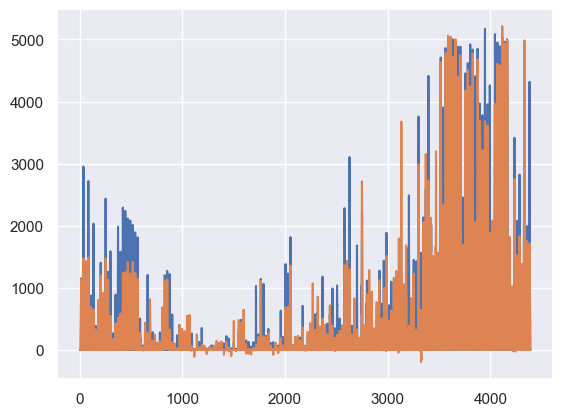

In [ ]:
plt.plot(y_train_scaler.inverse_transform(y_test))
plt.plot(y_train_scaler.inverse_transform(pred))

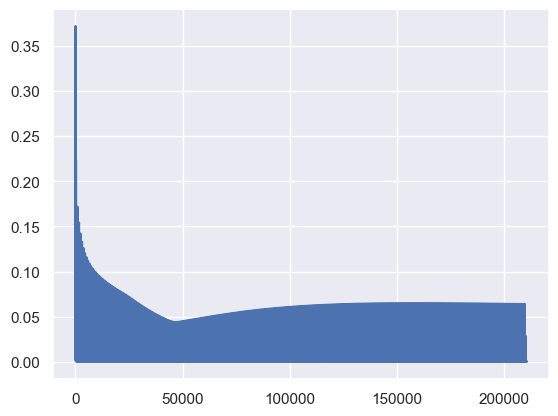

In [ ]:
plt.plot(train_loss,'-')

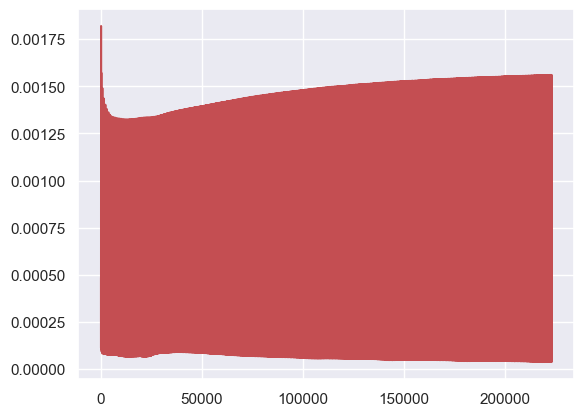

In [ ]:
plt.plot(test_loss,'r')

In [ ]:
X_test

array([[0.45945947, 0.32665512, 0.        , ..., 0.81818182, 1.        ,
        0.82191781],
       [0.44444446, 0.33013919, 0.        , ..., 0.81818182, 1.        ,
        0.82191781],
       [0.44744741, 0.31533107, 0.        , ..., 0.81818182, 1.        ,
        0.82465753],
       ...,
       [0.22222222, 0.48693391, 0.        , ..., 0.27272727, 1.33333333,
        0.3260274 ],
       [0.22222222, 0.48954696, 0.        , ..., 0.27272727, 1.33333333,
        0.3260274 ],
       [0.22222222, 0.48954696, 0.        , ..., 0.27272727, 1.33333333,
        0.3260274 ]])

In [ ]:
input = X_train.copy()

In [ ]:
predictions = np.array([])

for i in range(0, int(num_samples/batch_size -1)):
    features = Variable(torch.from_numpy(X_test).type(torch.FloatTensor)[i*batch_size:(i+1)*batch_size, :]).view(-1, seq_dim, feat_dim)

    predictions = np.append(predictions, model(features).detach().numpy())

In [ ]:
preds = y_train_scaler.inverse_transform(predictions.reshape(1, -1))

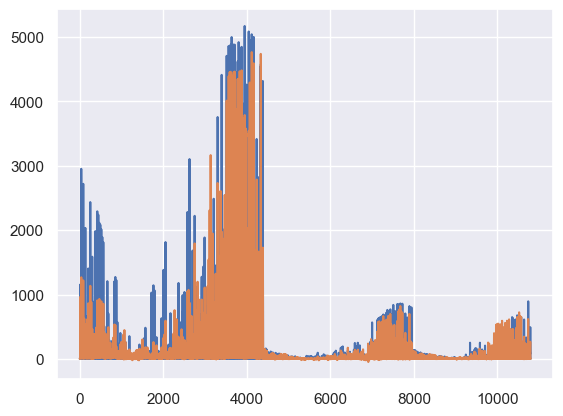

In [ ]:
plt.plot(y_train_scaler.inverse_transform(y_test))
plt.plot(y_train_scaler.inverse_transform(y_pred))

In [ ]:
y_test.shape

(10795, 1)

In [ ]:
preds.T.shape

(10795, 1)

In [ ]:
print(
    "MAE: ",
    round(
        mean_absolute_error(
            y_true=y_train_scaler.inverse_transform(y_test),
            y_pred=preds.T,
        ),
        3,
    ),
)

MAE:  152.992
